# NETWORK SCIENCE VK PROJECT

connecting some stuff

In [53]:
import requests
import time
import collections
import matplotlib.pyplot as plt
import networkx as nx
import operator
import pandas as pd
import numpy as np
import itertools
import scipy.spatial as spt
import seaborn as sns
sns.set()
%matplotlib inline

ModuleNotFoundError: No module named 'vk'

Всякие полезные функции для API

In [46]:
# функция возвращает список друзей
def get_friends_ids(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&v=5.8' 
    # также вы можете добавить access_token в запрос, получив его через OAuth 2.0
    json_response = requests.get(friends_url.format(user_id)).json()
    if json_response.get('error'):
        #print json_response.get('error')
        return list()
    return json_response[u'response']

In [47]:
requests.get('https://api.vk.com/method/friends.get?user_id=11759642&v=5.8' ).json()

{'error': {'error_code': 5,
  'error_msg': 'User authorization failed: no access_token passed.',
  'request_params': [{'key': 'oauth', 'value': '1'},
   {'key': 'method', 'value': 'friends.get'},
   {'key': 'user_id', 'value': '11759642'},
   {'key': 'v', 'value': '5.8'}]}}

In [40]:
# функция возвращает имя юзера
def find_name(id_interest):
    resp=requests.get('https://api.vk.com/method/users.get?user_ids={}&v=5.8'.format(id_interest)).json()[u'response']
    return resp[0][u'first_name'].strip()+' '+resp[0][u'last_name'].strip()

# функция пишет имя
def print_info_about(i, id_interest, G):  
    resp=requests.get('https://api.vk.com/method/users.get?user_ids={}&v=5.8'.format(id_interest)).json()[u'response']
    print(str(i)+". "+resp[0][u'first_name'].strip()+' '+resp[0][u'last_name'].strip()+' '+str(G.degree()[id_interest]))

Начинаем создавать граф

In [41]:
graph = {}
friend_ids = get_friends_ids(11759642)  # мой id

In [42]:
friend_ids

[]

In [7]:
num = 1
for friend_id in friend_ids["items"]:
   # print (str(num)+". "'Processing id: ', friend_id)
    friend_friends = get_friends_ids(friend_id)
    if len(friend_friends) > 0:
        graph[friend_id] = friend_friends["items"]
    num += 1

TypeError: list indices must be integers or slices, not str

In [ ]:
g = nx.Graph(directed=False)

In [ ]:
myfriends = list(graph.keys())
for i in myfriends:
    g.add_node(i)
    for j in graph[i]:
        if i != j and j in myfriends:
            g.add_edge(i, j)

Поскольку есть некрасивые отдельные вершины, не связанные ни с кем, я просто сразу беру максимальный подграф. 95% друзей туда входят. Но вообще это делать необязательно

In [ ]:
g = g.subgraph(max(nx.connected_component_subgraphs(g), key=len))

Запись графа

In [ ]:
nx.write_gml(g, "yulia_sheb_network.gml")

Запись графа с именами вместо ID

In [ ]:
G = nx.relabel_nodes(g, find_name)

In [ ]:
nx.write_gml(G, "yulia_sheb_network1.gml")

## ЗДЕСЬ ЗАКАНЧИВАЕТСЯ РАБОТА С API И НАЧИНАЕТСЯ АНАЛИЗ

Читаем графы

In [ ]:
'''
G1 = nx.read_gml('network.gml')
G = nx.read_gml('network1.gml')
'''

In [ ]:
G1 = nx.read_gml('yulia_sheb_network.gml')
G = nx.read_gml('yulia_sheb_network1.gml')

Смотрим всякие degree

In [ ]:
k = nx.degree(G)
k1 = nx.degree(G1)

In [ ]:
len(G.nodes()), len(G.edges())

In [ ]:
def plot_pdf(bincenters0, yh0, n):
    yh1 = np.array(yh0) / n
    plt.plot(bincenters0, yh1, '-', lw=2)
    plt.ylabel('count')
    plt.xlabel('degree')
    return 

def plot_cdf(degrees):
    degrees = sorted(degrees)
    cdf, degree, cur_sum, i, max_val = [], 0, 0, 0, sum(degrees)
    while i < len(degrees):
        if degree > degrees[i]:
            while degree > degrees[i]:
                cur_sum += degrees[i]
                i += 1
                if i == len(degrees):
                    break
        degree += 1
        cdf.append(cur_sum / max_val)
    plt.plot(np.arange(0, max(degrees)+1), cdf[:-1], '-', lw=2)
    plt.ylabel('count')
    plt.xlabel('degree')
    return

def get_bincenters(degrees, bins):
    yh0, binEdges=np.histogram(degrees, bins=bins)
    bincenters0 = 0.5*(binEdges[1:]+binEdges[:-1])
    return bincenters0, yh0

In [ ]:
degrees = list(nx.degree(G).values())

In [ ]:
hist0 = get_bincenters(degrees, 25)
plot_pdf(hist0[0], hist0[1], len(degrees))

In [ ]:
plot_cdf(degrees)

Заплотим некрасивый график (Gephi круче)

In [ ]:
plt.figure(1, figsize=(40,40))
coord = nx.spring_layout(G)
nx.draw_networkx(G,
                 pos=coord,
                 nodelist=list(k.keys()),
                 node_size = [d*20 for d in list(k.values())],
                 node_color=list(k.values()),
                 font_size=6,
                 cmap=plt.cm.Blues,
                 with_labels=True
                 )

Это граф для Gephi

In [ ]:
nx.write_gexf(G, "shm_graph.gexf")

# ДИАМЕТР

In [ ]:
diameter = nx.diameter(G.subgraph(max(nx.connected_component_subgraphs(G), key=len)))
diameter

# КОЭФФИЦИЕНТ КЛАСТЕРИЗАЦИИ

In [ ]:
clust_coef = nx.average_clustering(G)
clust_coef

# AVERAGE SHORTEST PATH LENGTH

In [6]:
avg_short_path = nx.average_shortest_path_length(G)
avg_short_path

NameError: name 'G' is not defined

Похоже, что это был временный чанк для загрузки в gephi, уже не помню, что он делал...

In [26]:
# pd.DataFrame(list(k.items()), columns=["vk_id", "degree"]).to_csv("mygraph.csv")

# РАСПРЕДЕЛЕНИЕ ВЕРШИН

In [27]:
k_new = sorted(k1.items(), key=operator.itemgetter(1), reverse=True)
k_new = [x[0] for x in k_new]
for i in range(0,11):
    print_info_about(i+1, k_new[i], G1)

1. Александр Пивненко 99
2. Алексей Шадрин 97
3. Константин Бородич 88
4. Дмитрий Мазаев 88
5. Полина Пасека 85
6. Дмитрий Михайлов 79
7. Ростислав Хелемский 76
8. Екатерина Алексеева 73
9. Амаль Имангулов 73
10. Ильгиз Сафин 72
11. Элина Шаймуратова 68


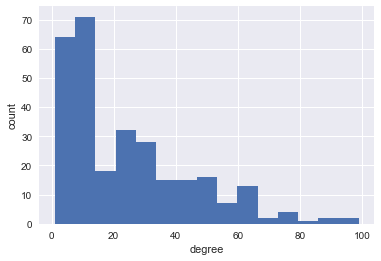

In [28]:
plt.hist(list(G.degree().values()), bins=15)
plt.ylabel('count')
plt.xlabel('degree')

#### Топ10 по degree centrality

In [29]:
k_new = sorted(nx.degree(G).items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_new[i][0], k_new[i][1])

1.  Александр Пивненко 99
2.  Алексей Шадрин 97
3.  Дмитрий Мазаев 88
4.  Константин Бородич 88
5.  Полина Пасека 85
6.  Дмитрий Михайлов 79
7.  Ростислав Хелемский 76
8.  Екатерина Алексеева 73
9.  Амаль Имангулов 73
10.  Ильгиз Сафин 72
11.  Элина Шаймуратова 68


# BETWENNESS CENTRALITY

In [30]:
bc = nx.betweenness_centrality(G)

#### Топ10 по betweenness centrality

In [31]:
k_bc = sorted(bc.items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_bc[i][0], k_bc[i][1])

1.  Виктория Тельминова 0.16397290027708794
2.  Алексей Шадрин 0.14317240612143523
3.  Амаль Имангулов 0.11473165418994906
4.  Элина Шаймуратова 0.10858363792093897
5.  Владислав Усиченко 0.08664893326026614
6.  Катерина Бекетова 0.06278042074339986
7.  Полина Пасека 0.057926171032622494
8.  Анна Копачёва 0.05410779507881584
9.  Константин Бородич 0.04284684396072912
10.  Алена Гурдина 0.040783774445941175
11.  Роман Тарин 0.037094166160836356


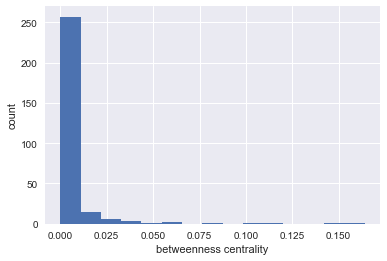

In [32]:
plt.hist(list(bc.values()), bins=15)
plt.ylabel('count')
plt.xlabel('betweenness centrality')

# CLOSENESS CENTRALITY

In [33]:
cc = nx.closeness_centrality(G)

#### Топ10 по closeness centrality

In [34]:
k_cc = sorted(cc.items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_cc[i][0], k_cc[i][1])

1.  Алексей Шадрин 0.5264116575591985
2.  Александр Пивненко 0.48983050847457626
3.  Элина Шаймуратова 0.4890016920473773
4.  Амаль Имангулов 0.48653198653198654
5.  Константин Бородич 0.4857142857142857
6.  Дмитрий Мазаев 0.480865224625624
7.  Полина Пасека 0.478476821192053
8.  Екатерина Алексеева 0.4609250398724083
9.  Юлия Мышляева 0.4609250398724083
10.  Семён Кирьяк 0.45800316957210774
11.  Дмитрий Михайлов 0.45368916797488223


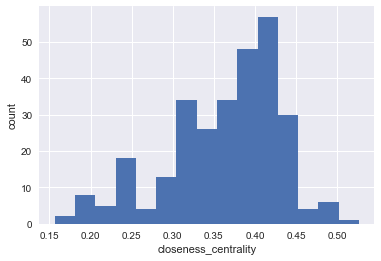

In [35]:
plt.hist(list(cc.values()), bins=15)
plt.ylabel('count')
plt.xlabel('closeness_centrality')

# PAGERANK

In [36]:
pr = nx.pagerank(G)

#### Топ10 по pagerank

In [37]:
k_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_pr[i][0], k_pr[i][1])

1.  Алексей Шадрин 0.010903482594095158
2.  Амаль Имангулов 0.010416813287826161
3.  Александр Пивненко 0.010074043352397864
4.  Полина Пасека 0.009710426633137714
5.  Константин Бородич 0.009174829134244538
6.  Дмитрий Мазаев 0.008798418348066772
7.  Глеб Гаращук 0.008157585714368813
8.  Дмитрий Михайлов 0.008144113846334154
9.  Сергей Стерхов 0.007825322787710828
10.  Ростислав Хелемский 0.0075387237434299805
11.  Ильгиз Сафин 0.007316607497950977


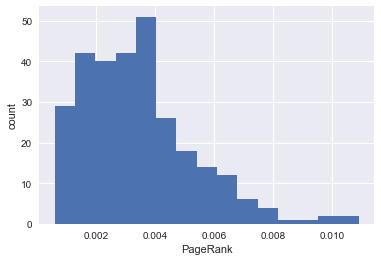

In [38]:
plt.hist(list(pr.values()), bins=15)
plt.ylabel("count")
plt.xlabel("PageRank")

In [39]:
pr, cc, bc, nx.degree(G)

({'Alexandr Gruzin': 0.0011668500429661728,
  'Alexey Guryev': 0.001559562001536171,
  'Andrei Logvinenko': 0.005884007338708488,
  'Anna Rakovskaya': 0.0018078198767404146,
  'Arina Kasamara': 0.0014915710230478758,
  'Beatrix Sharp': 0.0018747514799303338,
  'Dmitry Doroshko': 0.006053542332698525,
  'Farid Nadirogli': 0.003877912402110917,
  'Julia Mankova': 0.0031735551588740387,
  'July Sobko': 0.002970881478711015,
  'Margarita Belozerova': 0.0031036695159565347,
  'Maria Zhukova': 0.00558434763011973,
  'Natalia Belova': 0.005644176575692708,
  'Nikita Ballo': 0.0036884917912461098,
  'Olya Solodskaya': 0.002638154728983016,
  'Polina Koldomova': 0.0012737232788631496,
  'Rudolf Schenker': 0.003940302691884505,
  'Savr Taraskaev': 0.001779968493699221,
  'Svetlana Fedorova': 0.0014775817980617963,
  'Аделина Шайдуллина': 0.0023459994032857907,
  'Александр Белов': 0.0014471062431798208,
  'Александр Мишаков': 0.0013420398700530257,
  'Александр Мухгалин': 0.0058925983449585675,


In [40]:
def scatter_compare_centrality(dict1, dict2, name1, name2):
    x, y = [], []
    for item in pr.items():
        name = item[0]
        x.append(item[1])
        y.append(dict2[name])
    plt.scatter(x, y)
    plt.ylabel(name2)
    plt.xlabel(name1)
    return

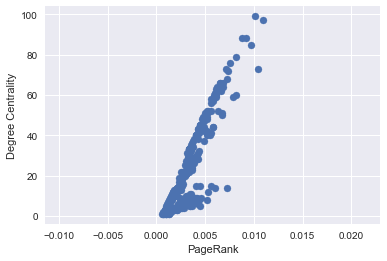

In [41]:
scatter_compare_centrality(pr, nx.degree(G), "PageRank", "Degree Centrality")

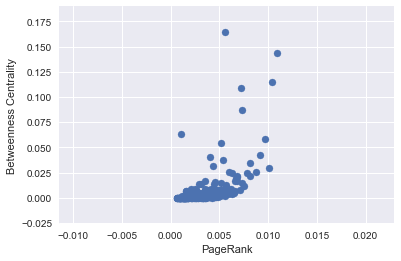

In [42]:
scatter_compare_centrality(pr, bc, "PageRank", "Betweenness Centrality")

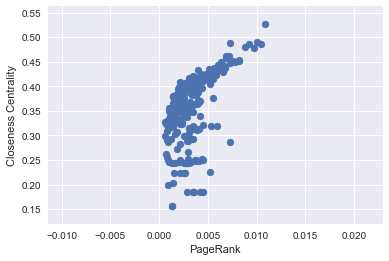

In [43]:
scatter_compare_centrality(pr, cc, "PageRank", "Closeness Centrality")

In [44]:
k_new

[('Александр Пивненко', 99),
 ('Алексей Шадрин', 97),
 ('Дмитрий Мазаев', 88),
 ('Константин Бородич', 88),
 ('Полина Пасека', 85),
 ('Дмитрий Михайлов', 79),
 ('Ростислав Хелемский', 76),
 ('Екатерина Алексеева', 73),
 ('Амаль Имангулов', 73),
 ('Ильгиз Сафин', 72),
 ('Элина Шаймуратова', 68),
 ('Семён Кирьяк', 66),
 ('Анастасия Сухарева', 66),
 ('Ваня Балабанов', 66),
 ('Кристина Акалович', 64),
 ('Юлия Мышляева', 64),
 ('Кирилл Нестеров', 64),
 ('Вита Тимофеева', 63),
 ('Марина Обнорская', 62),
 ('Валерия Гребенькова', 61),
 ('Dmitry Doroshko', 61),
 ('Глеб Гаращук', 60),
 ('Алексей Батищев', 60),
 ('Александр Мухгалин', 60),
 ('Сергей Стерхов', 59),
 ('Andrei Logvinenko', 59),
 ('Арсений Горохов', 59),
 ('Анастасия Карташова', 59),
 ('Maria Zhukova', 58),
 ('Дарья Киселева', 57),
 ('Natalia Belova', 56),
 ('Сергей Савельев', 52),
 ('Лена Изотова', 52),
 ('Влад Колесников', 52),
 ('Рамиль Измайлов', 52),
 ('Виктор Смирнов', 51),
 ('София Енокаева', 51),
 ('Анастасия Захарова', 51),


In [45]:
pd.DataFrame({
    "degree" : [x[0] for x in k_new][:10],
    "betweenness" : [x[0] for x in k_bc][:10],
    "closeness" : [x[0] for x in k_cc][:10],
    "pagerank" : [x[0] for x in k_pr][:10]})

,betweenness,closeness,degree,pagerank
0,Виктория Тельминова,Алексей Шадрин,Александр Пивненко,Алексей Шадрин
1,Алексей Шадрин,Александр Пивненко,Алексей Шадрин,Амаль Имангулов
2,Амаль Имангулов,Элина Шаймуратова,Дмитрий Мазаев,Александр Пивненко
3,Элина Шаймуратова,Амаль Имангулов,Константин Бородич,Полина Пасека
4,Владислав Усиченко,Константин Бородич,Полина Пасека,Константин Бородич
5,Катерина Бекетова,Дмитрий Мазаев,Дмитрий Михайлов,Дмитрий Мазаев
6,Полина Пасека,Полина Пасека,Ростислав Хелемский,Глеб Гаращук
7,Анна Копачёва,Екатерина Алексеева,Екатерина Алексеева,Дмитрий Михайлов
8,Константин Бородич,Юлия Мышляева,Амаль Имангулов,Сергей Стерхов
9,Алена Гурдина,Семён Кирьяк,Ильгиз Сафин,Ростислав Хелемский


# DISTANCE SIMILARITIES

Тут короч матрица смежности, корреляции, Евклидово и косинусное расстояния

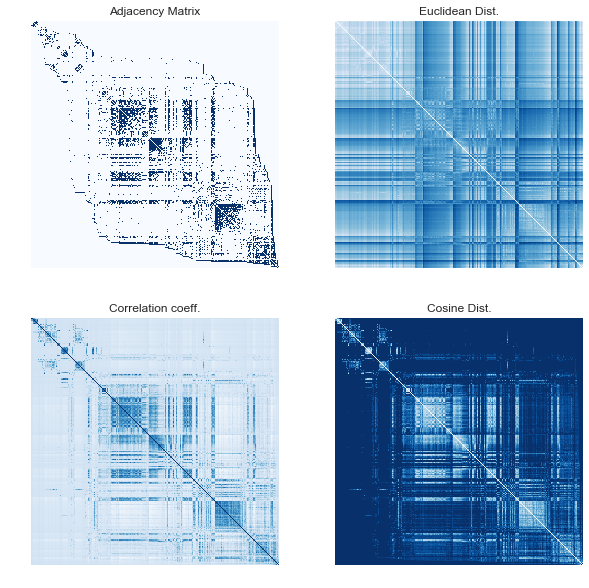

In [46]:
def plotDist(G):
    rcm = nx.utils.reverse_cuthill_mckee_ordering(G)
    A = nx.to_numpy_matrix(G, dtype=int, nodelist=list(rcm))
    A = np.asarray(A)
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Blues', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    ax[0, 0].axis('off')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    ax[1, 0].axis('off')
    
    dVec_euc = spt.distance.pdist(A, metric = 'euclidean')
    dVec_euc = spt.distance.squareform(dVec_euc)
    ax[0, 1].imshow(dVec_euc, cmap = 'Blues', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    ax[0, 1].axis('off')
    
    dVec_cos = spt.distance.pdist(A, metric = 'cosine')
    dVec_cos = spt.distance.squareform(dVec_cos)
    ax[1, 1].imshow(dVec_cos, cmap = 'Blues', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    ax[1, 1].axis('off')    
    return A, D, dVec_euc, dVec_cos


A, D, euc, cos = plotDist(G)

Похожие друг на друга личности

In [47]:
nodes = G.nodes()
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)
dVec_euc = spt.distance.pdist(A, metric = 'cosine')
dVec_euc = spt.distance.squareform(dVec_euc)
similar_friends = []
for i in range(len(dVec_euc)):
    for j in range(i+1, len(dVec_euc[i])):
        if dVec_euc[i,j] < 0.2 and i != j:
            similar_friends.append((nodes[i], nodes[j], float(dVec_euc[i,j])))
similar_friends = sorted(similar_friends, key=operator.itemgetter(2))
pd.set_option('display.precision',2)
similar_friends = pd.DataFrame(similar_friends, columns=['friend_1', 'friend_2', 'dist'])
similar_friends['dist'] = similar_friends['dist'].apply(lambda x: '{:.4f}'.format(x))
similar_friends.head(7)

,friend_1,friend_2,dist
0,Григорий Швецов,Polina Koldomova,0.0000
1,Артем Николаев,Таня Сонейкин,0.0909
2,Иван Фролов,Алексей Шередега,0.0995
3,Арсений Афанасьев,Юлия Фёдорова,0.1056
4,Роман Пинаев,Лиза Джой,0.1056
5,Анастасия Сухарева,Вита Тимофеева,0.1160
6,Артем Николаев,Сергей Сайганов,0.1296


# CLIQUES

Функция из лабы, которая работала вечность.

In [48]:
def FindKCliques(G, k):
    n = G.order()
    V = G.nodes()
    kCliques = []
    # Iterate over sizes
    for grSize in range(n, 1, -1):
        # Iterate over subgraphs
        for subV in itertools.combinations(V, grSize):
            # Not included in maximal and all distances are <= k
            if not any([set(subV).issubset(kcl) for kcl in kCliques]):
                if all([nx.shortest_path_length(G, pairs[0], pairs[1]) <= k for pairs in itertools.combinations(subV, 2)]):
                        kCliques.append(subV)
            
    return kCliques

Вместо нее использовал встроенную. Она мне понравилась больше.

На результате получаем cliques - это топовые клики

In [49]:
cliques = []
for i in nx.find_cliques(G):
    cliques.append((i, len(i)))
cliques = sorted(cliques, key=lambda tup: tup[1], reverse = True)

Взглянем на максимальный размер клик

In [50]:
[x[1] for x in cliques[:15]]

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19]

Ага, двадцать. И их четыре штуки. Ради интереса глянем, кто там

In [55]:
for i in cliques[:12]:
    print(str(i[0]))

['Марк Дрезин', 'Элина Шаймуратова', 'Екатерина Алексеева', 'Andrei Logvinenko', 'Вита Тимофеева', 'Анастасия Сухарева', 'Дмитрий Мазаев', 'Алёна Дёмина', 'Лена Шаркова', 'Анастасия Захарова', 'Мария Саликова', 'Константин Бородич', 'Александра Иванова', 'Олег Фурсенко', 'Николай Филиппенков', 'София Енокаева', 'Михаил Волчанский', 'Александр Мухгалин', 'Илья Сапунов', 'Полина Пасека']
['Марк Дрезин', 'Элина Шаймуратова', 'Екатерина Алексеева', 'Andrei Logvinenko', 'Вита Тимофеева', 'Анастасия Сухарева', 'Дмитрий Мазаев', 'Алёна Дёмина', 'Лена Шаркова', 'Анастасия Захарова', 'Мария Саликова', 'Константин Бородич', 'Александра Иванова', 'Олег Фурсенко', 'Николай Филиппенков', 'София Енокаева', 'Михаил Волчанский', 'Мария Ершова', 'Илья Сапунов', 'Полина Пасека']
['Марк Дрезин', 'Элина Шаймуратова', 'Екатерина Алексеева', 'Andrei Logvinenko', 'Вита Тимофеева', 'Анастасия Сухарева', 'Дмитрий Мазаев', 'Алёна Дёмина', 'Лена Шаркова', 'Анастасия Захарова', 'Мария Саликова', 'Эрдни Батаев', '

Ну а здесь смотрим, какие люди попали в эти максимальные клики сколько раз

In [56]:
names_in_top_clique = [item for sublist in [x[0] for x in cliques[:4]] for item in sublist]

In [57]:
d = {}
for name in names_in_top_clique:
    d[name] = names_in_top_clique.count(name)
sorted(d.items(), key=operator.itemgetter(1), reverse=True)

[('Марк Дрезин', 4),
 ('Элина Шаймуратова', 4),
 ('Екатерина Алексеева', 4),
 ('Andrei Logvinenko', 4),
 ('Вита Тимофеева', 4),
 ('Анастасия Сухарева', 4),
 ('Дмитрий Мазаев', 4),
 ('Алёна Дёмина', 4),
 ('Лена Шаркова', 4),
 ('Анастасия Захарова', 4),
 ('Мария Саликова', 4),
 ('Александра Иванова', 4),
 ('Олег Фурсенко', 4),
 ('Николай Филиппенков', 4),
 ('Илья Сапунов', 4),
 ('Полина Пасека', 4),
 ('София Енокаева', 3),
 ('Александр Мухгалин', 3),
 ('Константин Бородич', 2),
 ('Михаил Волчанский', 2),
 ('Эрдни Батаев', 2),
 ('Natalia Belova', 2),
 ('Мария Ершова', 1),
 ('Наран Бадма-Гаряев', 1)]

Какая неожиданность, везде одни и те же. Справедливости ради, все ребята с моего курса ФКН (кроме Александра Пивненко), так что это в какой-то степени отображает коммьюнити

Ну а тут просто построим гистрограммку по кликам

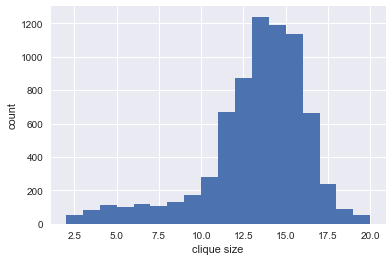

In [54]:
plt.hist([x[1] for x in cliques], bins=18)
plt.ylabel("count")
plt.xlabel("clique size")

# k-core

Здесь я запускал специальную функцию для поиска k-core, импортировал в файл, оттуда в Gephi. Напомню, там красивее.

In [ ]:
d = nx.core_number(G)
cocore = pd.Series(d)

In [ ]:
cocore

In [152]:
cocore.to_csv("filename.csv")

# RANDOM GENERATION

На каждую вероятность генерим по несколько графов и берем среднее значение. После этого рассматривается такая вот странная величина - смотрим, во сколько раз каждая из характеристик отклонилась от значения в моем графе, затем по всем характеристикам смотрим среднее и получаем число. Чем меньше число, тем лучше. Просто нужна была какая-то метрика, чтобы оценить "похожесть" графа, ну я вот выбрал такую

### Erdos-Renyi model

In [13]:
# get diameter, clustering coefficient, avg shortest path, number of edges, avg degree
def get_common_info(nG):
    nG_sub = nG.subgraph(max(nx.connected_component_subgraphs(nG), key=len))
    ndiameter = nx.diameter(nG_sub)
    nclust_coef = nx.average_clustering(nG_sub)
    navg_short_path = nx.average_shortest_path_length(nG_sub)
    return [ndiameter, nclust_coef, navg_short_path, len(nG.edges()), sum(nx.degree(nG).values())/n]

In [14]:
n = len(G.nodes())
true_params = [diameter, clust_coef, avg_short_path, len(G.edges()), sum(nx.degree(G).values())/n]

In [29]:
stats_er = []
iter = 10
for p in np.linspace(0.1, 0.9, 9):
    print("start iteration with p =", p, end='')
    cur_p_stats = []
    for i in range(iter):
        nG = nx.erdos_renyi_graph(n=n, p=p)
        cur_p_stats.append(get_common_info(nG))
        # to check the progress
        print("|", end='')
    print()
    stats_er.append((np.mean(cur_p_stats, axis=0), p))
print([diameter, clust_coef, avg_short_path, len(G.edges())])

start iteration with p = 0.1||||||||||
start iteration with p = 0.2||||||||||
start iteration with p = 0.3||||||||||
start iteration with p = 0.4||||||||||
start iteration with p = 0.5||||||||||
start iteration with p = 0.6||||||||||
start iteration with p = 0.7||||||||||
start iteration with p = 0.8||||||||||
start iteration with p = 0.9||||||||||
[7, 0.508731394000387, 2.5941723538070387, 5161]


In [30]:
df_er = pd.DataFrame([x[0] for x in stats_er], 
                   columns=['diameter', 'clustering', 'avg_shortest_path', 
                            'number_of_edges', 'avg_degree'])
df_er['p'] = [x[1] for x in stats_er]
df_er

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,p
0,3.0,0.100001,1.912178,8986.2,42.387736,0.1
1,2.0,0.200498,1.799383,17990.5,84.860849,0.2
2,2.0,0.299637,1.700319,26874.2,126.765094,0.3
3,2.0,0.400441,1.599737,35894.0,169.311321,0.4
4,2.0,0.499934,1.500191,44820.9,211.419340,0.5
5,2.0,0.599227,1.400734,53739.8,253.489623,0.6
6,2.0,0.699300,1.300696,62710.8,295.805660,0.7
7,2.0,0.800031,1.199981,71742.5,338.408019,0.8
8,2.0,0.899775,1.100222,80688.5,380.606132,0.9


In [31]:
df_er1 = df_er.copy()
df_er1['diameter'] = abs(pd.to_numeric(df_er1['diameter']) - true_params[0]) / true_params[0]
df_er1['clustering'] = abs(pd.to_numeric(df_er1['clustering']) - true_params[1]) / true_params[1]
df_er1['avg_shortest_path'] = abs(pd.to_numeric(df_er1['avg_shortest_path']) - true_params[2]) / true_params[2]
df_er1['number_of_edges'] = abs(pd.to_numeric(df_er1['number_of_edges']) - true_params[3]) / true_params[3]
df_er1['avg_degree'] = abs(pd.to_numeric(df_er1['avg_degree']) - true_params[4]) / true_params[4]
df_er1.head()

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,p
0,0.571429,0.803431,0.262895,0.741174,0.741174,0.1
1,0.714286,0.605886,0.306375,2.485855,2.485855,0.2
2,0.714286,0.411012,0.344562,4.207169,4.207169,0.3
3,0.714286,0.212864,0.383334,5.954854,5.954854,0.4
4,0.714286,0.017293,0.421707,7.684538,7.684538,0.5


In [32]:
df_er2 = df_er1[['diameter', 'clustering', 'avg_shortest_path', 
                            'number_of_edges']]
idx_er = df_er2.mean(axis=1).idxmin()
idx_er

0

In [33]:
df_er.iloc[idx_er,:]

diameter                3.000000
clustering              0.100001
avg_shortest_path       1.912178
number_of_edges      8986.200000
avg_degree             42.387736
p                       0.100000
Name: 0, dtype: float64

In [34]:
df_er2.mean(axis=1)[idx_er]

0.59473209030647922

## Watts-Strogatz model

In [35]:
stats_ws = []
iter = 10
for p in np.linspace(0.1, 0.9, 5):
    print("start iteration with p =", p)
    cur_p_stats = []
    for k in range(2, int(n/4), int(n/40)):
        print("start iteration with k =", k, end='\t')
        for i in range(iter):
            nG = nx.watts_strogatz_graph(n=n, k=k, p=p, seed=None)
            cur_p_stats.append(get_common_info(nG))
            # to check the progress
            print("|", end='')
        print()
        stats_ws.append((np.mean(cur_p_stats, axis=0), p, k))
print("SUCCESS")
print([diameter, clust_coef, avg_short_path, len(G.edges())])

start iteration with p = 0.1
start iteration with k = 2	||||||||||
start iteration with k = 12	||||||||||
start iteration with k = 22	||||||||||
start iteration with k = 32	||||||||||
start iteration with k = 42	||||||||||
start iteration with k = 52	||||||||||
start iteration with k = 62	||||||||||
start iteration with k = 72	||||||||||
start iteration with k = 82	||||||||||
start iteration with k = 92	||||||||||
start iteration with k = 102	||||||||||
start iteration with p = 0.3
start iteration with k = 2	||||||||||
start iteration with k = 12	||||||||||
start iteration with k = 22	||||||||||
start iteration with k = 32	||||||||||
start iteration with k = 42	||||||||||
start iteration with k = 52	||||||||||
start iteration with k = 62	||||||||||
start iteration with k = 72	||||||||||
start iteration with k = 82	||||||||||
start iteration with k = 92	||||||||||
start iteration with k = 102	||||||||||
start iteration with p = 0.5
start iteration with k = 2	||||||||||
start iteration w

In [37]:
df_ws = pd.DataFrame([x[0] for x in stats_ws], 
                   columns=['diameter', 'clustering', 'avg_shortest_path', 
                            'number_of_edges', 'avg_degree'])
df_ws['p'] = [x[1] for x in stats_ws]
df_ws['k'] = [x[2] for x in stats_ws]
df_ws['clustering'] = df_ws['clustering'].apply(lambda x: '{:.4f}'.format(x))
df_ws.head()

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,p,k
0,120.800,0.0000,43.398963,424.0,2.0,0.1,2
1,63.400,0.2505,23.429549,1484.0,7.0,0.1,12
2,43.600,0.3432,16.519192,2544.0,12.0,0.1,22
3,33.675,0.3918,12.999032,3604.0,17.0,0.1,32
4,27.540,0.4225,10.845982,4664.0,22.0,0.1,42


In [40]:
true_params = [diameter, clust_coef, avg_short_path, len(G.edges()), sum(nx.degree(G).values())/n]

In [41]:
df_ws1 = df_ws.copy()
df_ws1['diameter'] = abs(pd.to_numeric(df_ws1['diameter']) - true_params[0]) / true_params[0]
df_ws1['clustering'] = abs(pd.to_numeric(df_ws1['clustering']) - true_params[1]) / true_params[1]
df_ws1['avg_shortest_path'] = abs(pd.to_numeric(df_ws1['avg_shortest_path']) - true_params[2]) / true_params[2]
df_ws1['number_of_edges'] = abs(pd.to_numeric(df_ws1['number_of_edges']) - true_params[3]) / true_params[3]
df_ws1['avg_degree'] = abs(pd.to_numeric(df_ws1['avg_degree']) - true_params[4]) / true_params[4]
df_ws1.head()

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,p,k
0,16.257143,1.000000,15.729406,0.917845,0.917845,0.1,2
1,8.057143,0.507599,8.031608,0.712459,0.712459,0.1,12
2,5.228571,0.325381,5.367808,0.507072,0.507072,0.1,22
3,3.810714,0.229849,4.010859,0.301686,0.301686,0.1,32
4,2.934286,0.169503,3.180903,0.096299,0.096299,0.1,42


In [42]:
df_ws2 = df_ws1[['diameter', 'clustering', 'avg_shortest_path', 
                            'number_of_edges']]
idx_ws = df_ws2.mean(axis=1).idxmin()
idx_ws

31

In [43]:
df_ws.iloc[idx_ws,:]

diameter                8.31
clustering            0.1607
avg_shortest_path    4.00089
number_of_edges         9964
avg_degree                47
p                        0.5
k                         92
Name: 31, dtype: object

In [44]:
df_ws2.mean(axis=1)[idx_ws]

0.58603862621249092

In [45]:
true_params

[7, 0.508731394000387, 2.5941723538070387, 5161, 24.34433962264151]

## BARABASI-ALBERT model

In [19]:
stats_ba = []
iter = 10
for m in np.linspace(5, 100, 20):
    print("start iteration with m =", m, end='')
    cur_m_stats = []
    for i in range(iter):
        nG = nx.barabasi_albert_graph(n=n, m=int(m))
        cur_m_stats.append(get_common_info(nG))
        # to check the progress
        print("|", end='')
    print()
    stats_ba.append((np.mean(cur_m_stats, axis=0), m))

start iteration with m = 5.0||||||||||
start iteration with m = 10.0||||||||||
start iteration with m = 15.0||||||||||
start iteration with m = 20.0||||||||||
start iteration with m = 25.0||||||||||
start iteration with m = 30.0||||||||||
start iteration with m = 35.0||||||||||
start iteration with m = 40.0||||||||||
start iteration with m = 45.0||||||||||
start iteration with m = 50.0||||||||||
start iteration with m = 55.0||||||||||
start iteration with m = 60.0||||||||||
start iteration with m = 65.0||||||||||
start iteration with m = 70.0||||||||||
start iteration with m = 75.0||||||||||
start iteration with m = 80.0||||||||||
start iteration with m = 85.0||||||||||
start iteration with m = 90.0||||||||||
start iteration with m = 95.0||||||||||
start iteration with m = 100.0||||||||||


In [21]:
df_ba = pd.DataFrame([x[0] for x in stats_ba], 
                   columns=['diameter', 'clustering', 'avg_shortest_path', 
                            'number_of_edges'])
df_ba['m'] = [x[1] for x in stats_ba]
df_ba['clustering'] = df_ba['clustering'].apply(lambda x: '{:.4f}'.format(x))
df_ba.head()

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,m
0,4.2,0.0777,2.710161,2095.0,9.882075,5.0
1,3.4,0.1107,2.298389,4140.0,19.528302,10.0
2,3.0,0.1419,2.075556,6135.0,28.938679,15.0
3,3.0,0.1705,1.962030,8080.0,38.113208,20.0
4,3.0,0.1956,1.905169,9975.0,47.051887,25.0


In [24]:
df_ba1 = df_ba.copy()
df_ba1['diameter'] = abs(pd.to_numeric(df_ba1['diameter']) - true_params[0]) / true_params[0]
df_ba1['clustering'] = abs(pd.to_numeric(df_ba1['clustering']) - true_params[1]) / true_params[1]
df_ba1['avg_shortest_path'] = abs(pd.to_numeric(df_ba1['avg_shortest_path']) - true_params[2]) / true_params[2]
df_ba1['number_of_edges'] = abs(pd.to_numeric(df_ba1['number_of_edges']) - true_params[3]) / true_params[3]
df_ba1['avg_degree'] = abs(pd.to_numeric(df_ba1['avg_degree']) - true_params[4]) / true_params[4]
df_ba1.head()

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,m
0,0.400000,0.847267,0.044711,0.594071,0.594071,5.0
1,0.514286,0.782400,0.114019,0.197830,0.197830,10.0
2,0.571429,0.721071,0.199916,0.188723,0.188723,15.0
3,0.571429,0.664853,0.243678,0.565588,0.565588,20.0
4,0.571429,0.615514,0.265597,0.932765,0.932765,25.0


In [25]:
df_ba2 = df_ba1[['diameter', 'clustering', 'avg_shortest_path', 
                            'number_of_edges']]
idx_ba = df_ba2.mean(axis=1).idxmin()
idx_ba

1

In [26]:
df_ba.iloc[idx_ba,:]

diameter                 3.4
clustering            0.1107
avg_shortest_path    2.29839
number_of_edges         4140
avg_degree           19.5283
m                         10
Name: 1, dtype: object

Почему диаметр дробный - потому что бралось 10 графов для каждого параметра и все характеристики брались средние по ним. Ну здесь, судя по всему, было штук 6 графов с диаметром 3 и штуки 4 с диаметром 4

In [27]:
df_ba2.mean(axis=1)[idx_ba]

0.40213350585817076

Зато этот показатель получился прям неплохой...

In [28]:
true_params

[7, 0.508731394000387, 2.5941723538070387, 5161, 24.34433962264151]

In [46]:
df_er

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,p
0,3.0,0.100001,1.912178,8986.2,42.387736,0.1
1,2.0,0.200498,1.799383,17990.5,84.860849,0.2
2,2.0,0.299637,1.700319,26874.2,126.765094,0.3
3,2.0,0.400441,1.599737,35894.0,169.311321,0.4
4,2.0,0.499934,1.500191,44820.9,211.419340,0.5
5,2.0,0.599227,1.400734,53739.8,253.489623,0.6
6,2.0,0.699300,1.300696,62710.8,295.805660,0.7
7,2.0,0.800031,1.199981,71742.5,338.408019,0.8
8,2.0,0.899775,1.100222,80688.5,380.606132,0.9


In [48]:
df_ws

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,p,k
0,120.800000,0.0000,43.398963,424.0,2.0,0.1,2
1,63.400000,0.2505,23.429549,1484.0,7.0,0.1,12
2,43.600000,0.3432,16.519192,2544.0,12.0,0.1,22
3,33.675000,0.3918,12.999032,3604.0,17.0,0.1,32
4,27.540000,0.4225,10.845982,4664.0,22.0,0.1,42
5,23.450000,0.4439,9.382579,5724.0,27.0,0.1,52
6,20.528571,0.4595,8.319981,6784.0,32.0,0.1,62
7,18.337500,0.4718,7.513570,7844.0,37.0,0.1,72
8,16.633333,0.4824,6.881104,8904.0,42.0,0.1,82
9,15.270000,0.4909,6.371690,9964.0,47.0,0.1,92


In [47]:
df_ba

,diameter,clustering,avg_shortest_path,number_of_edges,avg_degree,m
0,4.2,0.0777,2.710161,2095.0,9.882075,5.0
1,3.4,0.1107,2.298389,4140.0,19.528302,10.0
2,3.0,0.1419,2.075556,6135.0,28.938679,15.0
3,3.0,0.1705,1.962030,8080.0,38.113208,20.0
4,3.0,0.1956,1.905169,9975.0,47.051887,25.0
5,3.0,0.2202,1.872374,11820.0,55.754717,30.0
6,3.0,0.2413,1.849206,13615.0,64.221698,35.0
7,3.0,0.2640,1.828936,15360.0,72.452830,40.0
8,2.9,0.2836,1.809853,17055.0,80.448113,45.0
9,2.4,0.3033,1.791476,18700.0,88.207547,50.0
